# Flow analysis of the Oslo city bikes network

### Authors: Niclas Classen & Manuel Knepper
**TL;DR:** This notebook is used to analyze the flow of the Oslo City Bike network. The data for the bike rides is taken from https://oslobysykkel.no/en/open-data and the data for the city districts is taken from https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b.

**Reproducibility:** The repository contains the raw and preprocessed data as well as the code to reproduce the analysis. The notebook is written to run from top to bottom.

## Part 1: Data Preprocessing

#### Data Sources:
- Oslo City Bike Data: https://oslobysykkel.no/en/open-data
- Oslo Districts Geojson: https://kartkatalog.dev.geonorge.no/metadata/administrative-enheter-kommuner/041f1e6e-bdbc-4091-b48f-8a5990f3cc5b

#### Data Structure
The data is stored in the following folder structure:
- `data/`: Contains all the raw and preprocessed data
- `data/monthly`: Contains the monthly raw data for the bike rides
- `data/oslo_districts.geojson`: Contains the geojson file of the Oslo districts

As result of the data preprocessing, we have the following files:
- `data/preprocessed_bike_rides.csv`: Contains the preprocessed bike rides data of all months

In [2]:
import pandas as pd
import os
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
# !!! Set the path to the data directory in the .env file !!!
_path = os.environ.get("PATH_TO_DATA_DIRECTORY")

#### Create one file for all bike rides

In [5]:
# The following runs for 2 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5

dir_path = os.path.join(_path, 'monthly')
export_path = os.path.join(_path)

# Get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
dataframes = []

for file in tqdm(csv_files):
    # Extract year and month from filename
    year, month = file.split('.')[0].split('_')

    # Read csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))

    # Add a new column for the month and year
    df['month'] = month
    df['year'] = year

    # Check if the DataFrame is not empty or does not contain only NaN values (avoid warning when concatenating dfs)
    if not df.empty and not df.isna().all().all():
        dataframes.append(df)

# Concatenate all dataframes into a single dataframe
if dataframes:
    combined_df = pd.concat(dataframes)

    # Write the combined dataframe to a new csv file in the export directory
    combined_df.to_csv(f'{export_path}/preprocessed_bike_rides.csv', index=False)

100%|██████████| 61/61 [00:28<00:00,  2.13it/s]
/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_19905/23710081.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dataframes)


In [7]:
# First look at the data
combined_df.head(3)

started_at                          ended_at  \
0  2023-10-01 00:00:40.773000+00:00  2023-10-01 00:04:34.682000+00:00   
1  2023-10-01 03:01:18.390000+00:00  2023-10-01 03:08:24.193000+00:00   
2  2023-10-01 03:06:04.201000+00:00  2023-10-01 03:09:44.839000+00:00   

  duration start_station_id   start_station_name start_station_description  \
0      233              507    Jens Bjelkes Gate       ved Trondheimsveien   
1      425              607  Marcus Thranes gate             ved Akerselva   
2      220              500          Anker Hotel            langs Storgata   

   start_station_latitude  start_station_longitude end_station_id  \
0               59.919147                10.764130           2339   
1               59.932772                10.758595            393   
2               59.917279                10.758155            506   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude month year  
0             59.915649              10.761725    10   23  
1             59.939244              10.774319    10   23  
2             59.920128              10.768875    10   23

## Part 2: Data Analysis

In [236]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Polygon
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from geopandas.tools import sjoin
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler
import osmnx as ox
from itertools import combinations
from scipy.spatial import cKDTree

### Helper functions
First we define some helper functions to load the data that we need for the analysis.

In [6]:
def create_stations_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    df = df.copy()  # Create a copy to avoid changing the original DataFrame

    # Create unique dataframes for start and end stations
    start_stations = df[
        [
            "start_station_id",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()
    end_stations = df[
        [
            "end_station_id",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].drop_duplicates()

    # Rename columns for uniformity
    start_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]
    end_stations.columns = [
        "station_id",
        "station_name",
        "station_description",
        "latitude",
        "longitude",
        "month",
        "year",
    ]

    # Concatenate the dfs and drop duplicates
    stations = pd.concat([start_stations, end_stations]).drop_duplicates()
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations,
        geometry=gpd.points_from_xy(stations.longitude, stations.latitude),
        crs=crs_in,
    )
    gdf_stations = gdf_stations.to_crs(epsg=crs_out)

    return gdf_stations

def create_rides_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    df = df.copy()  # Create a copy to avoid changing the original DataFrame
    
    # Create a new DataFrame with necessary columns
    df_rides = df[
        [
            "start_station_id",
            "end_station_id",
            "started_at",
            "ended_at",
            "duration",
            "start_station_name",
            "start_station_description",
            "start_station_latitude",
            "start_station_longitude",
            "end_station_name",
            "end_station_description",
            "end_station_latitude",
            "end_station_longitude",
            "month",
            "year",
        ]
    ].copy() # copy to avoid warning

    # Create LineString objects
    df_rides.loc[:, "geometry"] = df_rides.apply(
        lambda row: LineString(
            [
                (row["start_station_longitude"], row["start_station_latitude"]),
                (row["end_station_longitude"], row["end_station_latitude"]),
            ]
        ),
        axis=1,
    )

    # Create GeoDataFrame
    gdf_rides = gpd.GeoDataFrame(df_rides, geometry="geometry", crs=crs_in)
    gdf_rides = gdf_rides.to_crs(epsg=crs_out)
    return gdf_rides

def create_oslo_districts_gdf(
    data_path: str = "data/oslo_districts.geojson",
    crs_in: int = 32633,
    crs_out: int = 3857,
) -> gpd.GeoDataFrame:
    gdf_oslo_districts = gpd.read_file(data_path)

    print(gdf_oslo_districts.crs)
    # Set the correct CRS
    gdf_oslo_districts.set_crs(crs_in, inplace=True, allow_override=True)

    # Reproject the data
    gdf_oslo_districts = gdf_oslo_districts.to_crs(epsg=crs_out)

    # Rename columns
    gdf_oslo_districts = gdf_oslo_districts.rename(columns={"bydelnavn": "district"})

    return gdf_oslo_districts

### 2.1 General data analysis

In [7]:
# The following runs for 5 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5

# Read the preprocessed data
df = pd.read_csv(f'{_path}/preprocessed_bike_rides.csv')

# Create GeoDataFrames for stations and rides
gdf_stations_unfiltered = create_stations_gdf(df) # don't filtered by month or year (so that we can analyse the differences in stations over time)
gdf_stations = gdf_stations_unfiltered.drop_duplicates(subset=['station_id']) # get all unique stations that ever existed
gdf_stations_last_month = create_stations_gdf(df.loc[(df['year'] == 24) & (df['month'] == 4)]) # get stations from april 2024
gdf_stations_last_year = create_stations_gdf(df.loc[((df['year'] == 23) & (df['month'] >= 5)) | ((df['year'] == 24) & (df['month'] < 5))]).drop_duplicates(subset=['station_id']) # get stations from mai 2023 to april 2024 (last year)

gdf_rides = create_rides_gdf(df)
gdf_rides_last_year = create_rides_gdf(df.loc[((df['year'] == 23) & (df['month'] >= 5)) | ((df['year'] == 24) & (df['month'] < 5))]) # rides from mai 2023 to april 2024 (last year)

# Create GeoDataFrame for Oslo districts
gdf_oslo_districts = create_oslo_districts_gdf()

EPSG:4326


In [ ]:
# Save data as geojson. This might be useful for the case where you have to reload the data

# gdf_stations_unfiltered.to_file(f'{_path}/gdf_stations_unfiltered.geojson', driver='GeoJSON')
# gdf_stations.to_file(f'{_path}/gdf_stations.geojson', driver='GeoJSON')
# gdf_stations_last_month.to_file(f'{_path}/gdf_stations_last_month.geojson', driver='GeoJSON')
# gdf_stations_last_year.to_file(f'{_path}/gdf_stations_last_year.geojson', driver='GeoJSON')

# gdf_rides.to_file(f'{_path}/gdf_rides.geojson', driver='GeoJSON')
# gdf_rides_last_year.to_file(f'{_path}/gdf_rides_last_year.geojson', driver='GeoJSON')

#### 2.1.1 Let's have a first look at the data

##### Oslo Bike Stations

In [8]:
print("Stations gdf unfiltered shape:", gdf_stations_unfiltered.shape)
print("Stations filtered by station_id gdf shape:", gdf_stations.shape)
print("Stations filtered by station_id last month gdf shape:", gdf_stations_last_month.shape)
print("Stations filtered by station_id last year gdf shape:", gdf_stations_last_year.shape)
gdf_stations.head(3)

Stations gdf unfiltered shape: (15332, 8)
Stations filtered by station_id gdf shape: (286, 8)
Stations filtered by station_id last month gdf shape: (267, 8)
Stations filtered by station_id last year gdf shape: (273, 8)


station_id         station_name  station_description   latitude  longitude  \
0         507    Jens Bjelkes Gate  ved Trondheimsveien  59.919147  10.764130   
1         607  Marcus Thranes gate        ved Akerselva  59.932772  10.758595   
2         500          Anker Hotel       langs Storgata  59.917279  10.758155   

   month  year                         geometry  
0     10    23  POINT (1198257.424 8381758.913)  
1     10    23  POINT (1197641.308 8384785.559)  
2     10    23  POINT (1197592.370 8381344.042)

In [237]:
gdf_stations.explore()

##### Bike Rides

In [10]:
print("Rides gdf shape:", gdf_rides.shape)
print("Rides gdf of last year shape:", gdf_rides_last_year.shape)
gdf_rides.head(3)

Rides gdf shape: (7897309, 16)
Rides gdf of last year shape: (1106880, 16)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name         end_station_description  \
0                  Elgsletta              langs Nylandsveien   
1  Hans Nielsen Hauges plass  langs Hans Nielsen Hauges gate   
2         Botanisk Hage vest                 ved Blytts gate   

   end_station_latitude  end_station_longitude  month  year  \
0             59.915649              10.761725     10    23   
1             59.939244              10.774319     10    23   
2             59.920128              10.768875     10    23   

                                            geometry  
0  LINESTRING (1198257.424 8381758.913, 1197989.6...  
1  LINESTRING (1197641.308 8384785.559, 1199391.7...  
2  LINESTRING (1197592.370 8381344.042, 1198785.7...

##### Oslo City Districts

In [70]:
print("Oslo districts gdf shape:", gdf_oslo_districts.shape)
gdf_oslo_districts.head(3)

Oslo districts gdf shape: (17, 3)


district bydelnr  \
0            Frogner  030105   
1           Østensjø  030113   
2  Søndre Nordstrand  030115   

                                            geometry  
0  MULTIPOLYGON (((1189421.693 8375826.292, 11864...  
1  MULTIPOLYGON (((1206718.020 8369118.365, 12067...  
2  MULTIPOLYGON (((1210120.108 8358267.151, 12100...

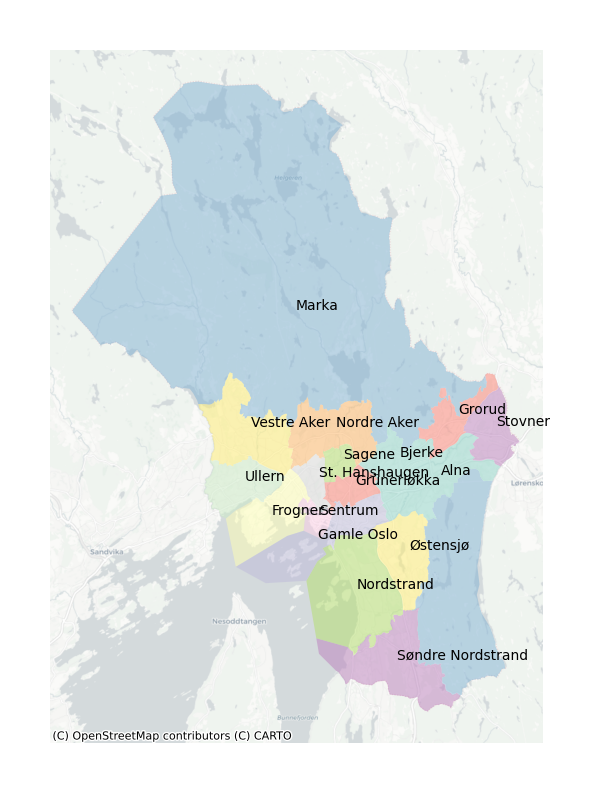

In [84]:
# Plot the different districts in Oslo
ax = gdf_oslo_districts.plot(column='district', cmap='Set3', alpha=0.5, figsize=(9, 9))

# Add a basemap
cx.add_basemap(ax, crs=gdf_oslo_districts.crs, source=cx.providers.CartoDB.Positron)

# Add the name of each district
for x, y, label in zip(gdf_oslo_districts.geometry.centroid.x, gdf_oslo_districts.geometry.centroid.y, gdf_oslo_districts['district']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.set_axis_off()
ax.set_aspect('equal')

#### 2.1.2 Changes of the station network over the years

In [72]:
# Split the stations GeoDataFrame by year
gdf_stations_by_year = {}
difference_stations_by_year = {}

for year in range(19, 25):
    gdf_stations_by_year[year] = gdf_stations_unfiltered[gdf_stations_unfiltered['year'] == year].drop_duplicates(subset=['station_id'])

    if year != 19:
        difference_stations_by_year[f'{year - 1}_{year}'] = set(gdf_stations_by_year[year]['station_id'].unique()) - set(gdf_stations_by_year[year - 1]['station_id'].unique())
        difference_stations_by_year[f'{year}_{year - 1}'] = set(gdf_stations_by_year[year - 1]['station_id'].unique()) - set(gdf_stations_by_year[year]['station_id'].unique())

In [13]:
# Get number of unique stations for entire dataset and for different years
for year, df in gdf_stations_by_year.items():
    number = df['station_id'].nunique()
    print(f"Number of stations in {year}: {number}")

Number of stations in 19: 254
Number of stations in 20: 255
Number of stations in 21: 262
Number of stations in 22: 269
Number of stations in 23: 273
Number of stations in 24: 268


##### Changes from 2019 to 2024 (general overview)

In [128]:
gdf_stations_2019 = gdf_stations_by_year[19]
gdf_stations_2024 = gdf_stations_by_year[24]

stations_2019 = gdf_stations_2019['station_id'].unique()
stations_2024 = gdf_stations_2024['station_id'].unique()

# remove existing stations from 2024
difference_19_24 = set(stations_2024) - set(stations_2019)
difference_24_19 = set(stations_2019) - set(stations_2024)

stations_change_2024_2019_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_19_24))]
stations_change_2019_2024_df = gdf_stations_2019.loc[gdf_stations_2019['station_id'].isin(list(difference_24_19))]

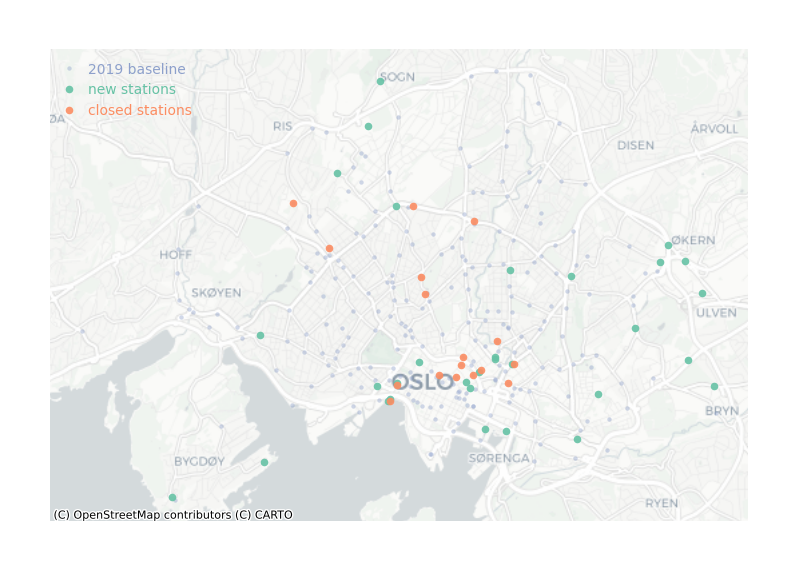

In [130]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_by_year[19].plot(alpha=0.4, ax=ax, color='#8da0cb', markersize=10, label='2019 baseline')
stations_change_2024_2019_df.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=30, label='new stations')
stations_change_2019_2024_df.plot(alpha=0.9, ax=ax, color='#fc8d62', markersize=30, label='closed stations')

ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_by_year[19].crs, source=cx.providers.CartoDB.Positron)

plt.savefig(f'figures/stations_change_2019_2024.png', bbox_inches='tight', pad_inches=0)
plt.show()

##### Yearly changes

In [110]:
# We already have the data for 2019 and 2024, but the other years are missing
gdf_stations_2020 = gdf_stations_by_year[20]
gdf_stations_2021 = gdf_stations_by_year[21]
gdf_stations_2022 = gdf_stations_by_year[22]
gdf_stations_2023 = gdf_stations_by_year[23]

stations_2020 = gdf_stations_2020['station_id'].unique()
stations_2021 = gdf_stations_2021['station_id'].unique()
stations_2022 = gdf_stations_2022['station_id'].unique()
stations_2023 = gdf_stations_2023['station_id'].unique()

# get differences between the years
difference_19_20 = set(stations_2020) - set(stations_2019)
difference_20_19 = set(stations_2019) - set(stations_2020)

difference_20_21 = set(stations_2021) - set(stations_2020)
difference_21_20 = set(stations_2020) - set(stations_2021)

difference_21_22 = set(stations_2022) - set(stations_2021)
difference_22_21 = set(stations_2021) - set(stations_2022)

difference_22_23 = set(stations_2023) - set(stations_2022)
difference_23_22 = set(stations_2022) - set(stations_2023)

difference_23_24 = set(stations_2024) - set(stations_2023)
difference_24_23 = set(stations_2023) - set(stations_2024)

# Datasets with changes in stations from year to year
stations_change_2019_2020_df = gdf_stations_2020.loc[gdf_stations_2020['station_id'].isin(list(difference_19_20))]
stations_change_2020_2019_df = gdf_stations_2019.loc[gdf_stations_2019['station_id'].isin(list(difference_20_19))]

stations_change_2020_2021_df = gdf_stations_2021.loc[gdf_stations_2021['station_id'].isin(list(difference_20_21))]
stations_change_2021_2020_df = gdf_stations_2020.loc[gdf_stations_2020['station_id'].isin(list(difference_21_20))]

stations_change_2021_2022_df = gdf_stations_2022.loc[gdf_stations_2022['station_id'].isin(list(difference_21_22))]
stations_change_2022_2021_df = gdf_stations_2021.loc[gdf_stations_2021['station_id'].isin(list(difference_22_21))]

stations_change_2022_2023_df = gdf_stations_2023.loc[gdf_stations_2023['station_id'].isin(list(difference_22_23))]
stations_change_2023_2022_df = gdf_stations_2022.loc[gdf_stations_2022['station_id'].isin(list(difference_23_22))]

stations_change_2023_2024_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_23_24))]
stations_change_2024_2023_df = gdf_stations_2023.loc[gdf_stations_2023['station_id'].isin(list(difference_24_23))]

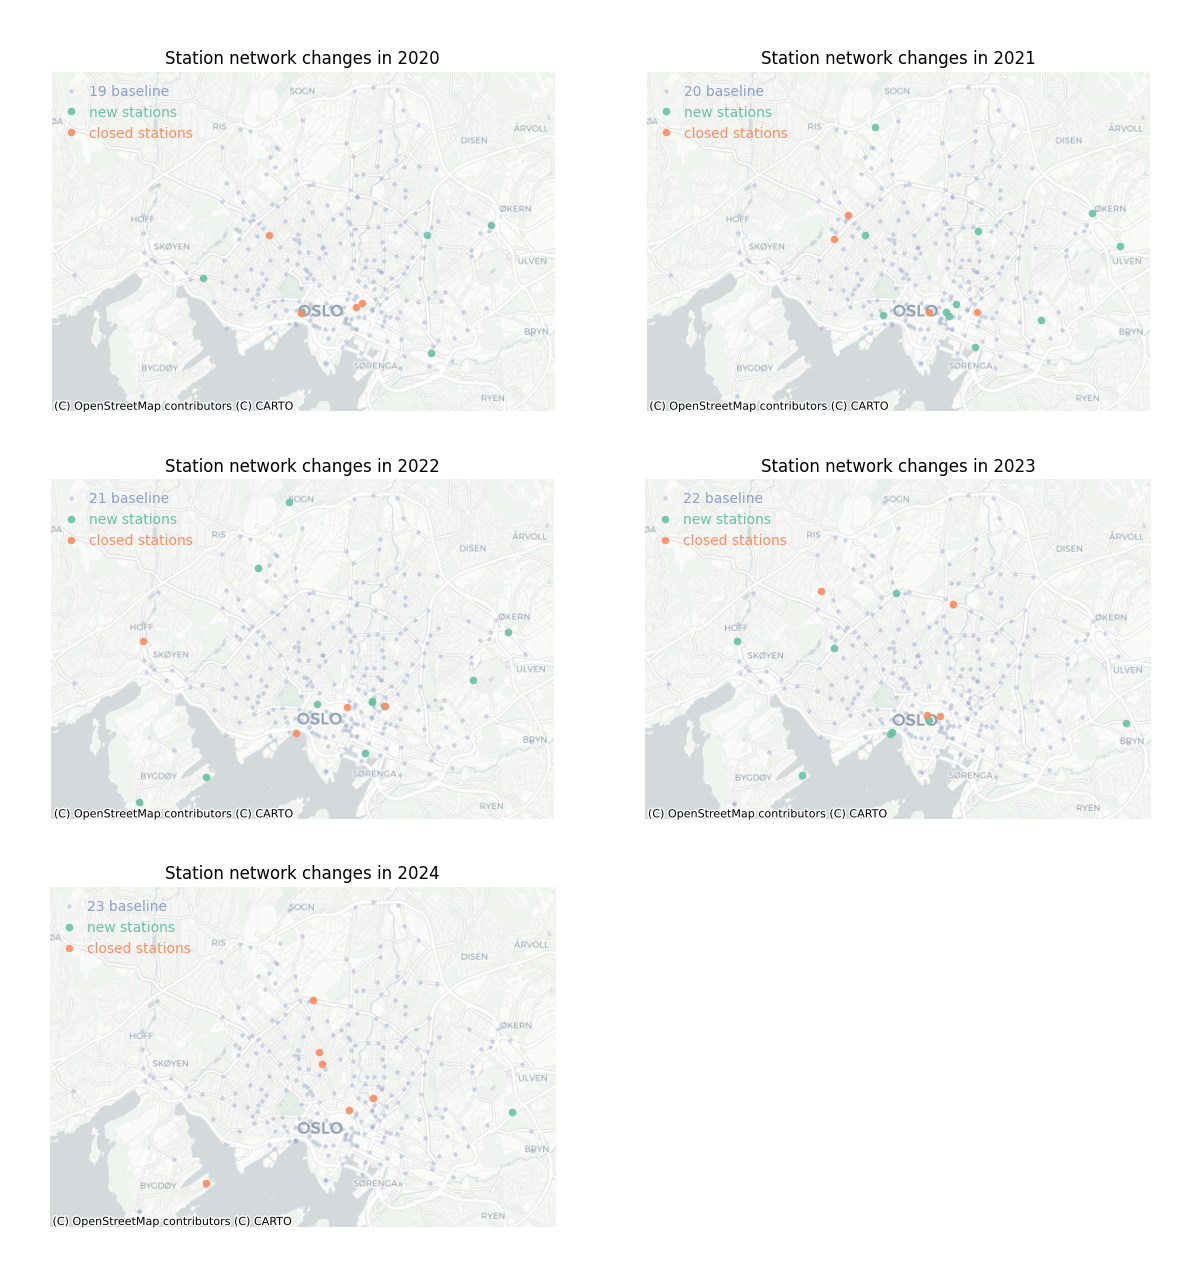

In [132]:
# list of dfs with new stations
df_new_list = [stations_change_2019_2020_df, stations_change_2020_2021_df, 
               stations_change_2021_2022_df, stations_change_2022_2023_df, 
               stations_change_2023_2024_df]

# list of dfs with old stations
df_closed_list = [stations_change_2020_2019_df, stations_change_2021_2020_df, 
                  stations_change_2022_2021_df, stations_change_2023_2022_df, 
                  stations_change_2024_2023_df]

years = list(range(20, 25))

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs = axs.flatten()

for i, (df_new, df_closed) in enumerate(zip(df_new_list, df_closed_list)):
    gdf_stations_by_year[years[i]-1].plot(alpha=0.4, ax=axs[i], color='#8da0cb', markersize=10, label=f'{years[i]-1} baseline')
    df_new.plot(alpha=0.9, ax=axs[i], color='#66c2a5', markersize=30, label='new stations')
    df_closed.plot(alpha=0.9, ax=axs[i], color='#fc8d62', markersize=30, label='closed stations')

    axs[i].set_axis_off()
    axs[i].set_title(f'Station network changes in 20{years[i]}')

    # Add legend
    axs[i].legend(labelcolor= ['#8da0cb','#66c2a5', '#fc8d62'],loc='upper left')

    # Add basemap
    cx.add_basemap(axs[i], crs=gdf_stations_by_year[years[i]-1].crs, source=cx.providers.CartoDB.Positron)

plt.subplots_adjust(wspace=0.05)

# Remove the last empty
fig.delaxes(axs[-1])


plt.savefig(f'figures/stations_change_all_years.png', bbox_inches='tight', pad_inches=0)
plt.show()

#### 2.1.3 Basic behavior of the bike rides

##### Distribution of rental durations

In [133]:
# function to format y-tick labels
def thousands(x, pos):
    return '%1.0fK' % (x * 0.001)

In [134]:
def plot_histogram_of_trip_durations(gdf_rides_input, plot_title):
    
    formatter = FuncFormatter(thousands)

    # Format durations to minutes and cap them at 100 minutes
    gdf_rides_input['duration_in_minutes'] = gdf_rides_input['duration'] / 60
    gdf_rides_input['duration_capped'] = np.where(gdf_rides_input['duration_in_minutes'] > 100, 100, gdf_rides_input['duration_in_minutes'])

    # Calculate 75th percentile
    percentiles = np.percentile(gdf_rides_input['duration_capped'], [75])

    sns.set_color_codes('pastel')

    # Create a histogram of the capped durations
    sns.histplot(gdf_rides_input['duration_capped'], bins=50, color='b', edgecolor="none")

    # Add vertical lines for the percentiles
    for percentile in percentiles:
        plt.axvline(x=percentile, color='r', linestyle='--')
        plt.text(percentile+1, plt.gca().get_ylim()[1], '75th percentile', color='r', rotation=90, verticalalignment='top')

    # Set the title and labels of the plot
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Duration (minutes)', fontsize=12)
    plt.ylabel('Number of trips', fontsize=12)

    # Set x-axis labels to increments of 5
    plt.xticks(np.arange(0, max(gdf_rides_input['duration_capped'])+5, 5))

    # Format y-axis labels to thousands
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.savefig(f'figures/histogram_trip_durations.png', bbox_inches='tight', pad_inches=0)
    plt.show()

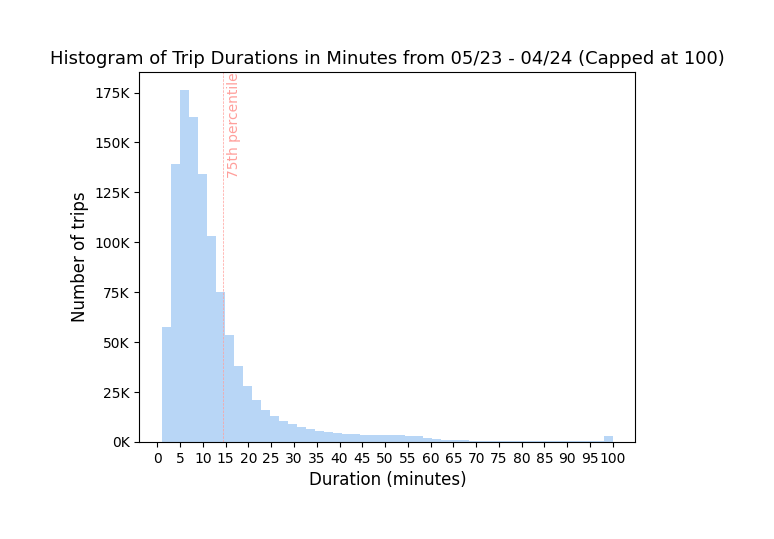

In [135]:
plot_title = 'Histogram of Trip Durations in Minutes from 05/23 - 04/24 (Capped at 100)'
plot_histogram_of_trip_durations(gdf_rides_last_year, plot_title)

##### Number of rides per day

In [136]:
# this is a small helper function to parse the dates
def custom_date_parser(d):
    return parse(d)

In [137]:
# TODO: fix labels
def plot_number_of_rides_per_day(gdf_rides_input, plot_title):
    tqdm.pandas()

    # Convert 'started_at' to datetime format
    gdf_rides_input['started_at_converted'] = gdf_rides_input['started_at'].progress_apply(custom_date_parser)

    # Extract the hour and day of the week
    gdf_rides_input['day'] = gdf_rides_input['started_at_converted'].dt.day
    gdf_rides_input['hour'] = gdf_rides_input['started_at_converted'].dt.hour
    gdf_rides_input['day_of_week'] = gdf_rides_input['started_at_converted'].dt.dayofweek
    gdf_rides_input['weekday_or_weekend'] = gdf_rides_input['day_of_week'].progress_apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

    bins = list(range(0, 25, 1))  # Create bins for each hour
    labels = [f'{i}-{i+1}' for i in bins[:-1]]  # Create labels for each bin
    gdf_rides_input['hour_interval'] = pd.cut(gdf_rides_input['hour'], bins=bins, labels=labels, right=False)

    # Group by 'day', 'hour_interval', and 'weekday_or_weekend' and count the number of trips
    grouped = gdf_rides_input.groupby(['day_of_week', 'hour_interval', 'weekday_or_weekend'], observed=True).size().reset_index(name='num_trips')

    plt.figure(figsize=(15, 8))
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Hour of the Day', fontsize=12)
    plt.ylabel('Number of Trips', fontsize=12)
    
    sns.lineplot(data=grouped, x='hour_interval', y='num_trips', hue='weekday_or_weekend')


    plt.savefig(f'figures/number_of_rides_per_day.png', bbox_inches='tight', pad_inches=0)
    plt.show()

100%|██████████| 1106880/1106880 [00:00<00:00, 1803126.61it/s]


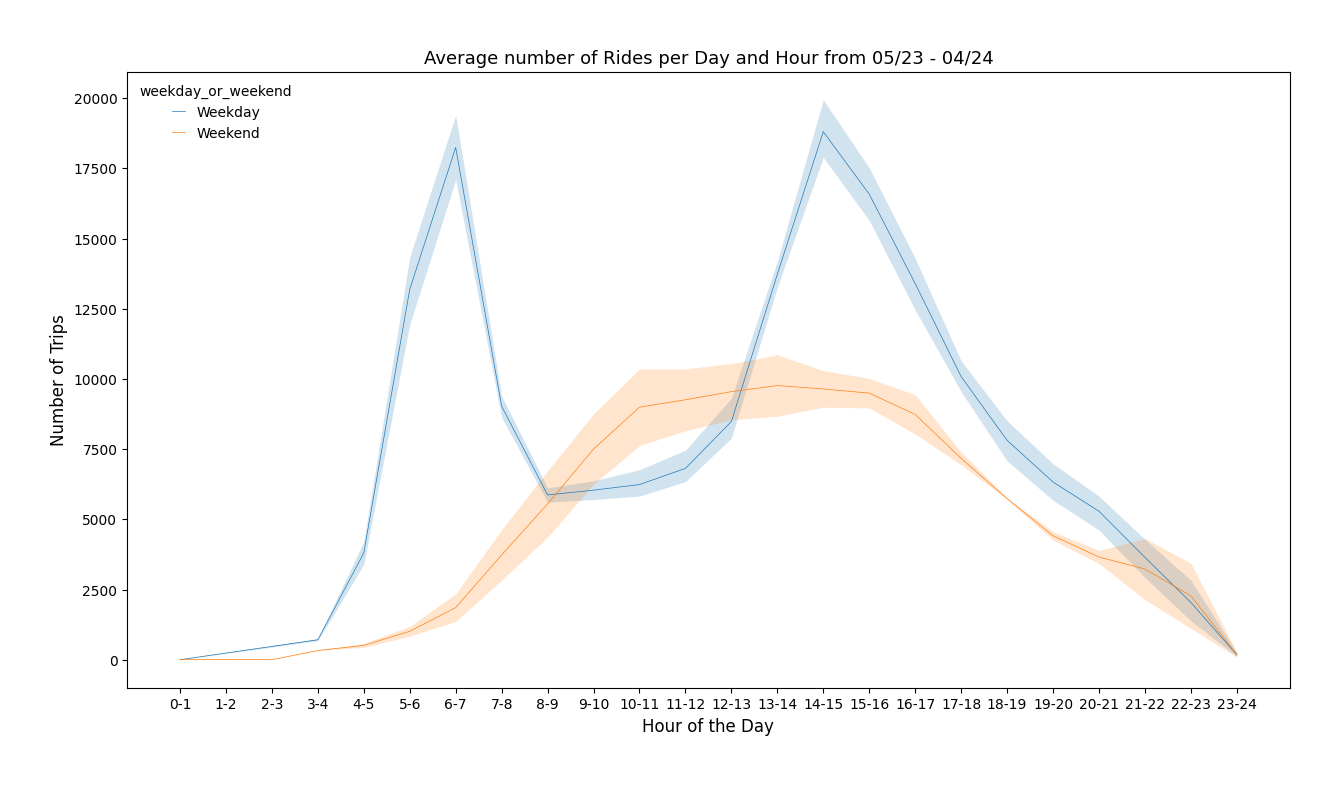

In [138]:
# The following runs for 15 minutes on a 2019 MacBook Pro with 16GB RAM and 1,4 GHz Quad-Core Intel Core i5 for all the rides and 2 mins for the last year
plot_title = 'Average number of Rides per Day and Hour from 05/23 - 04/24'
plot_number_of_rides_per_day(gdf_rides_last_year, plot_title)

In [139]:
# Number of rides per hour interval
number_of_trips_weekend_weekday = gdf_rides_last_year.groupby(['hour_interval', 'weekday_or_weekend'], observed=True).size().reset_index(name='num_trips')

# Let's print the actual number of trips
print('Number of trips on weekdays:')
print(number_of_trips_weekend_weekday.loc[number_of_trips_weekend_weekday['weekday_or_weekend'] == 'Weekday'])
print('-----------------------------------')
print('Number of trips on weekends:')
print(number_of_trips_weekend_weekday.loc[number_of_trips_weekend_weekday['weekday_or_weekend'] == 'Weekend'])

Number of trips on weekdays:
   hour_interval weekday_or_weekend  num_trips
0            0-1            Weekday          3
4            3-4            Weekday       3560
6            4-5            Weekday      19027
8            5-6            Weekday      65954
10           6-7            Weekday      91220
12           7-8            Weekday      45143
14           8-9            Weekday      29348
16          9-10            Weekday      30201
18         10-11            Weekday      31194
20         11-12            Weekday      34075
22         12-13            Weekday      42413
24         13-14            Weekday      68651
26         14-15            Weekday      94021
28         15-16            Weekday      82910
30         16-17            Weekday      66990
32         17-18            Weekday      50420
34         18-19            Weekday      39073
36         19-20            Weekday      31652
38         20-21            Weekday      26439
40         21-22            Wee

##### Average trip duration per day

In [140]:
def plot_avg_trip_duration_per_day(gdf_rides_input, plot_title):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_mapping = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    gdf_rides_input['day_of_week_name'] = gdf_rides_input['day_of_week'].map(day_mapping)
    
    average_duration = gdf_rides_input.groupby('day_of_week_name')['duration_in_minutes'].mean()
    average_duration = average_duration.reindex(weekdays)
    
    print(f'{plot_title}: ')
    print(average_duration)

    sns.set_color_codes('pastel')
    sns.barplot(x=average_duration.values, y=average_duration.index, color='b', orient='h')

    # Set the title and labels of the plot
    plt.title(plot_title, fontsize=13)
    plt.xlabel('Average trip duration (minutes)', fontsize=12)
    plt.ylabel('Day of the Week', fontsize=12)

    plt.savefig(f'figures/avg_trip_duration_per_day.png', bbox_inches='tight', pad_inches=0)
    plt.show()


Average Trip Duration per Day of the Week from 05/23 - 04/24: 
day_of_week_name
Monday       12.003564
Tuesday      11.635371
Wednesday    11.745624
Thursday     12.060669
Friday       12.337010
Saturday     14.679039
Sunday       15.518452
Name: duration_in_minutes, dtype: float64


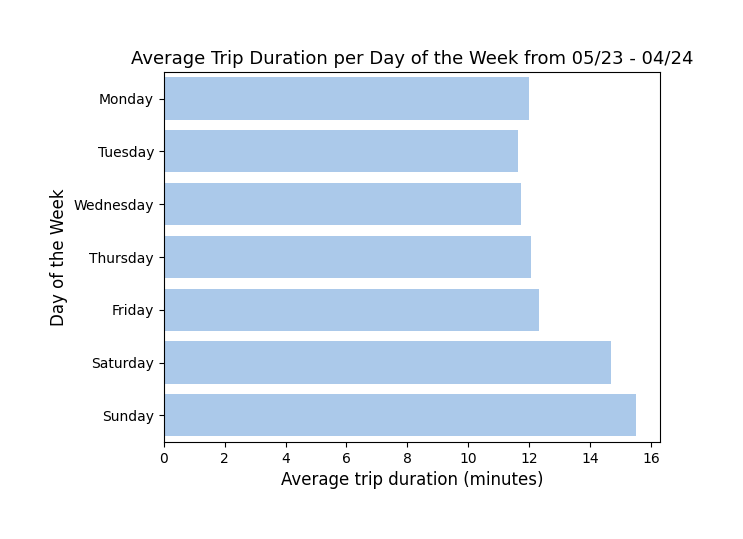

In [141]:
plot_avg_trip_duration_per_day(gdf_rides_last_year, 'Average Trip Duration per Day of the Week from 05/23 - 04/24')

### 2.2 Flow analysis

#### 2.2.1 Flow between stations

In [142]:
def get_unique_rides_count(gdf_rides_input):
    gdf_rides_unique = gdf_rides_input.drop_duplicates(subset=['start_station_id','end_station_id']).copy()
    gdf_rides_unique['count'] = gdf_rides_input.groupby(['start_station_id','end_station_id'])['start_station_id'].transform('count')

    return gdf_rides_unique

In [144]:
# get all start and end station combinations and the count
gdf_rides_unique = get_unique_rides_count(gdf_rides_last_year)
print(gdf_rides_unique.shape)
gdf_rides_unique.head(3)

(60994, 26)


start_station_id  end_station_id                        started_at  \
0               507            2339  2023-10-01 00:00:40.773000+00:00   
1               607             393  2023-10-01 03:01:18.390000+00:00   
2               500             506  2023-10-01 03:06:04.201000+00:00   

                           ended_at  duration   start_station_name  \
0  2023-10-01 00:04:34.682000+00:00       233    Jens Bjelkes Gate   
1  2023-10-01 03:08:24.193000+00:00       425  Marcus Thranes gate   
2  2023-10-01 03:09:44.839000+00:00       220          Anker Hotel   

  start_station_description  start_station_latitude  start_station_longitude  \
0       ved Trondheimsveien               59.919147                10.764130   
1             ved Akerselva               59.932772                10.758595   
2            langs Storgata               59.917279                10.758155   

            end_station_name  ...             started_at_converted  day  hour  \
0                  Elgsletta  ... 2023-10-01 00:00:40.773000+00:00    1     0   
1  Hans Nielsen Hauges plass  ... 2023-10-01 03:01:18.390000+00:00    1     3   
2         Botanisk Hage vest  ... 2023-10-01 03:06:04.201000+00:00    1     3   

   day_of_week  weekday_or_weekend hour_interval duration_in_minutes  \
0            6             Weekend           0-1            3.883333   
1            6             Weekend           3-4            7.083333   
2            6             Weekend           3-4            3.666667   

   duration_capped  day_of_week_name  count  
0         3.883333            Sunday     64  
1         7.083333            Sunday     17  
2         3.666667            Sunday     40  

[3 rows x 26 columns]

In [146]:
# scale the count column
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1))
gdf_rides_unique_scaled = gdf_rides_unique.copy()
gdf_rides_unique_scaled['count'] = np.clip(min_max_scaler.transform(np.array(list(gdf_rides_unique['count'])).reshape(-1, 1)), 0, 1)

# make sure the max value is 1 and the min value is 0
print("max", gdf_rides_unique_scaled['count'].max())
print("min", gdf_rides_unique_scaled['count'].min())

max 1.0
min 0.0


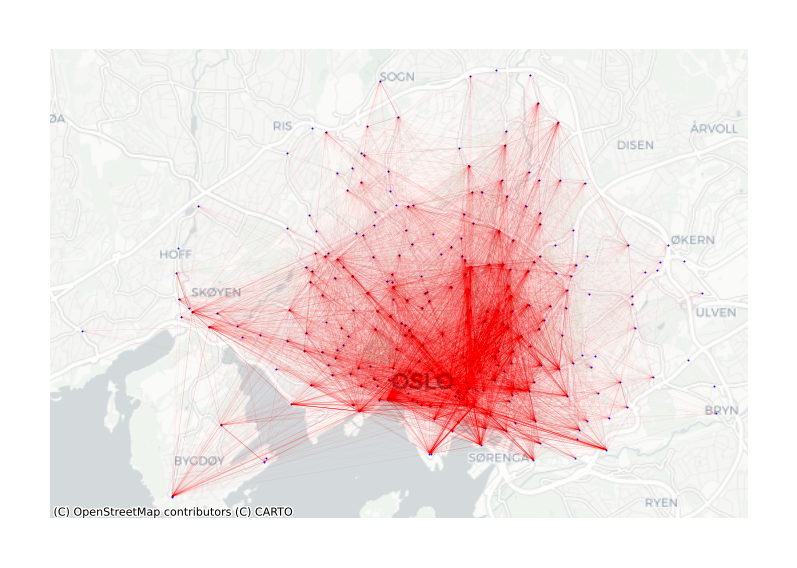

In [161]:
# plot the flow between stations scaled on transparency by the number of rides
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_unique_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_scaled['count'], ax=ax, color='red')
gdf_stations_last_year.plot(alpha=0.9, markersize=2, ax=ax, color='blue')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations_last_year.crs, source=cx.providers.CartoDB.Positron)
plt.savefig(f'figures/flow_between_stations.png', bbox_inches='tight', pad_inches=0)

##### Flow of new stations

In [35]:
# gdf_stations_2019 = gdf_stations_unfiltered.loc[gdf_stations_unfiltered['year'] == 19]
# gdf_stations_2024 = gdf_stations_unfiltered.loc[gdf_stations_unfiltered['year'] == 24]
# stations_2019 = gdf_stations_2019['station_id'].unique()
# stations_2024 = gdf_stations_2024['station_id'].unique()
# difference_19_24 = set(stations_2024) - set(stations_2019)
# stations_change_2024_2019_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_19_24))]

In [155]:
# get rides from or to all new stations
rides_new_stations_start = gdf_rides.loc[gdf_rides['start_station_id'].isin(list(difference_19_24))]
rides_new_stations_end = gdf_rides.loc[gdf_rides['end_station_id'].isin(list(difference_19_24))]

# combine dataframes
frames = [rides_new_stations_start, rides_new_stations_end]
rides_new_stations = pd.concat(frames)

In [156]:
# TODO: rename testdf ... and make it more readable
# TODO: does rides also include rides that start or end in one of the stations that got opened and closed in between?

# Preprocessing
gdf_rides_unique_19_24 = rides_new_stations.drop_duplicates(subset=['start_station_id','end_station_id'])
rides_count_19_24 =rides_new_stations.groupby(['start_station_id', 'end_station_id'])['start_station_latitude'].count()
testdf_19_24 = pd.DataFrame(data=rides_count_19_24.index, columns=['station_ids'])
testdf2_19_24 = pd.DataFrame(data=rides_count_19_24.values, columns=['count'])
rides_count_19_24_df = pd.merge(testdf_19_24, testdf2_19_24, left_index=True, right_index=True)
rides_count_19_24_df[['start_station_id','end_station_id']] = rides_count_19_24_df.station_ids.apply( 
   lambda x: pd.Series(str(x).split(","))) 
rides_count_19_24_df['start_station_id'] = rides_count_19_24_df['start_station_id'].str[1:]
rides_count_19_24_df['end_station_id'] = rides_count_19_24_df['end_station_id'].str.rstrip(')')
rides_count_19_24_df['start_station_id'] = pd.to_numeric(rides_count_19_24_df['start_station_id'])
rides_count_19_24_df['end_station_id'] = pd.to_numeric(rides_count_19_24_df['end_station_id'])
gdf_rides_unique_count_19_24 = pd.merge(gdf_rides_unique_19_24, rides_count_19_24_df, 'inner',on=['start_station_id', 'end_station_id'])

In [165]:
min_max_scaler_19_24 = MinMaxScaler()
min_max_scaler_19_24.fit(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))
gdf_rides_unique_count_19_24_scaled = gdf_rides_unique_count_19_24.copy()
gdf_rides_unique_count_19_24_scaled['count'] = min_max_scaler_19_24.transform(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))

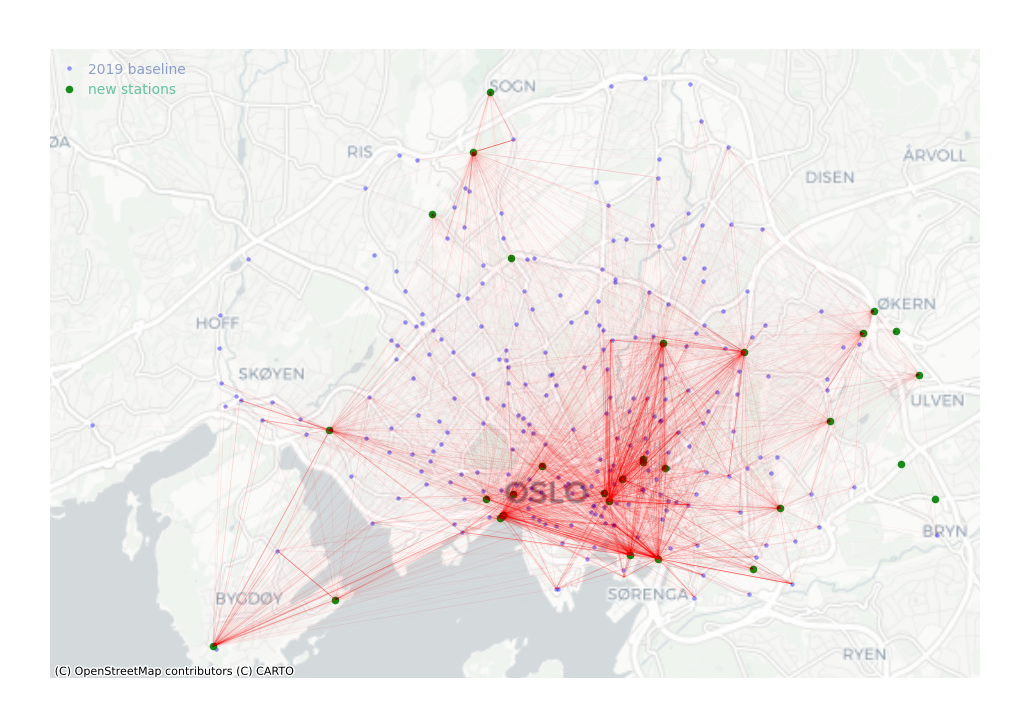

In [169]:
# TODO: add label for line?
f, ax = plt.subplots(1, figsize=(12, 12))
gdf_rides_unique_count_19_24_scaled.plot(linewidth= 0.5, alpha=gdf_rides_unique_count_19_24_scaled['count'], ax=ax, color='red') # TODO: what line width?
gdf_stations_2019.plot(alpha=0.4, markersize=10, ax=ax, color='blue', label='2019 baseline') # TODO: is it really the baseline
stations_change_2024_2019_df.plot(alpha=0.9, markersize=30, ax=ax, color='green', label='new stations')
ax.set_axis_off()

plt.legend(labelcolor= ['#8da0cb','#66c2a5'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_2024.crs, source=cx.providers.CartoDB.Positron)
plt.savefig(f'figures/flow_between_new_stations_19_24.png', bbox_inches='tight', pad_inches=0)

##### Flow between districts

In [176]:
# Perform a spatial join between the stations and the districts
joined = sjoin(gdf_stations_last_year, gdf_oslo_districts, how='left', predicate='within')

# The 'district' column in 'joined' now contains the district of each station
gdf_stations_last_year['district'] = joined['district_right'] 
gdf_stations_last_year.head(5)

station_id         station_name  station_description   latitude  longitude  \
0         507    Jens Bjelkes Gate  ved Trondheimsveien  59.919147  10.764130   
1         607  Marcus Thranes gate        ved Akerselva  59.932772  10.758595   
2         500          Anker Hotel       langs Storgata  59.917279  10.758155   
3         599            Paléhaven     langs Strandgata  59.910331  10.750110   
4         597          Fredensborg    ved rundkjøringen  59.920995  10.750358   

   month  year                         geometry        district  
0     10    23  POINT (1198257.424 8381758.913)     Grünerløkka  
1     10    23  POINT (1197641.308 8384785.559)          Sagene  
2     10    23  POINT (1197592.370 8381344.042)     Grünerløkka  
3     10    23  POINT (1196696.771 8379801.076)         Sentrum  
4     10    23  POINT (1196724.378 8382169.263)  St. Hanshaugen

In [178]:
# map rides to districts
district_dict = gdf_stations_last_year.set_index('station_id')['district'].to_dict()

gdf_rides_last_year['start_district'] = gdf_rides_last_year['start_station_id'].map(district_dict)
gdf_rides_last_year['end_district'] = gdf_rides_last_year['end_station_id'].map(district_dict)

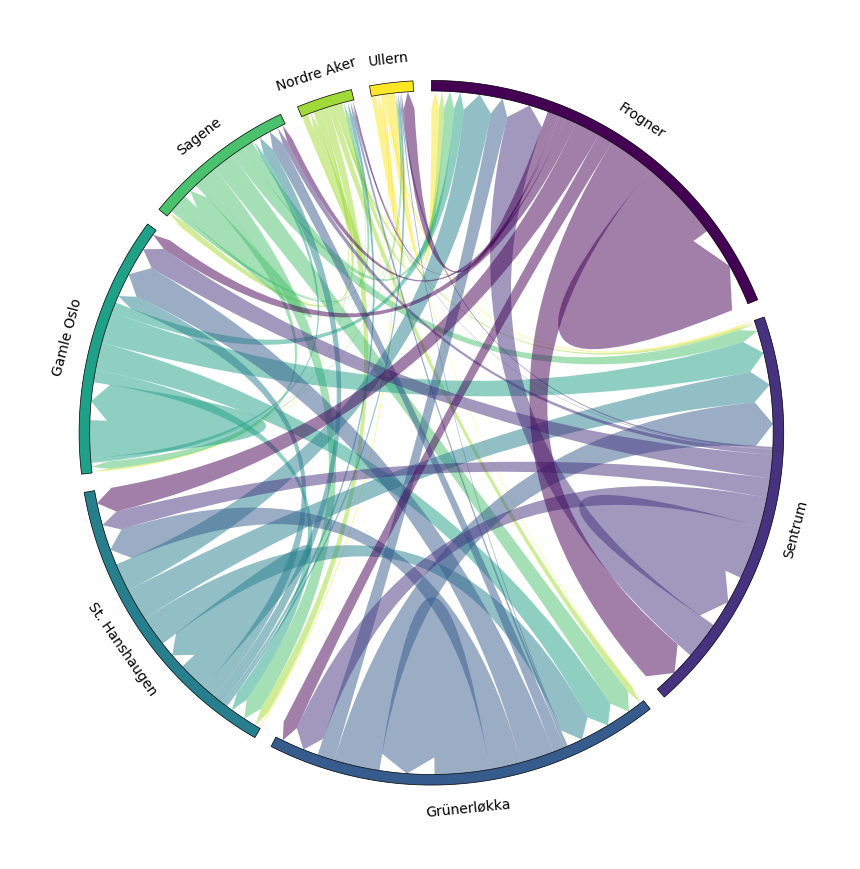

In [190]:
# create circos plot to visualize the flow between stations
districts = pd.concat([gdf_rides_last_year['start_district'], gdf_rides_last_year['end_district']])

top_districts = districts.value_counts().head(8) # limit it to top 8. Otherwise not readable
filtered_gdf_rides = gdf_rides_last_year[gdf_rides_last_year['start_district'].isin(top_districts.index) & gdf_rides_last_year['end_district'].isin(top_districts.index)]

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_district', 'end_district']).size().unstack().fillna(0)
matrix_df = pd.DataFrame(from_to_table, index=top_districts.index, columns=top_districts.index)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    label_kws=dict(size=10, r=105),
    link_kws=dict(direction=1, ec="black", lw=0),
)
fig = circos.plotfig()
plt.savefig(f'figures/circos_plot.png', bbox_inches='tight', pad_inches=0)

### 2.3 Spatial autocorrelation

#### Choropleth map to get a first impression

In [203]:
# remove all rides where start_station_id or end_station_id is not in gdf_stations_by_year[24]
gdf_stations_choropleth = gdf_stations_by_year[24] # get stations from 2024

gdf_rides_with_valid_stations = gdf_rides_last_year.loc[gdf_rides_last_year['start_station_id'].isin(gdf_stations_choropleth['station_id']) & gdf_rides_last_year['end_station_id'].isin(gdf_stations_choropleth['station_id'])]
gdf_rides_with_valid_stations.shape

(1083570, 27)

In [208]:
# spatial join between the stations and the districts
joined = sjoin(gdf_stations_choropleth, gdf_oslo_districts, how='left', predicate='within')
gdf_stations_choropleth['district'] = joined['district_right']

gdf_stations_choropleth.head(3)

station_id station_name station_description   latitude  longitude  \
6360154         403    Parkveien   ved trikkestoppet  59.921768  10.730476   
6360155         464  Sukkerbiten       ved gangbroen  59.905124  10.753764   
6360156         426   Gimle Kino   ved Frogner Kirke  59.917281  10.708376   

         month  year                         geometry district  
6360154      4    24  POINT (1194511.124 8382340.955)  Frogner  
6360155      4    24  POINT (1197103.483 8378645.102)  Sentrum  
6360156      4    24  POINT (1192050.941 8381344.349)  Frogner

In [209]:
# Group gdf_rides by 'start_station_id' and count the number of rides
rides_start = gdf_rides_with_valid_stations.groupby('start_station_id').size().reset_index(name='num_rides_start')
gdf_stations_choropleth = gdf_stations_choropleth.merge(rides_start, left_on='station_id', right_on='start_station_id', how='left')

# Group gdf_rides by 'end_station_id' and count the number of rides
rides_end = gdf_rides_with_valid_stations.groupby('end_station_id').size().reset_index(name='num_rides_end')
gdf_stations_choropleth = gdf_stations_choropleth.merge(rides_end, left_on='station_id', right_on='end_station_id', how='left')
gdf_stations_choropleth.shape

(268, 13)

In [210]:
#  group and sum number of start and end rides
district_rides_start = gdf_stations_choropleth.groupby('district')['num_rides_start'].sum().reset_index(name='num_rides_start')
district_rides_end = gdf_stations_choropleth.groupby('district')['num_rides_end'].sum().reset_index(name='num_rides_end')

# merge
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_start, on='district', how='left')
gdf_oslo_districts = gdf_oslo_districts.merge(district_rides_end, on='district', how='left')
gdf_oslo_districts.shape

(17, 5)

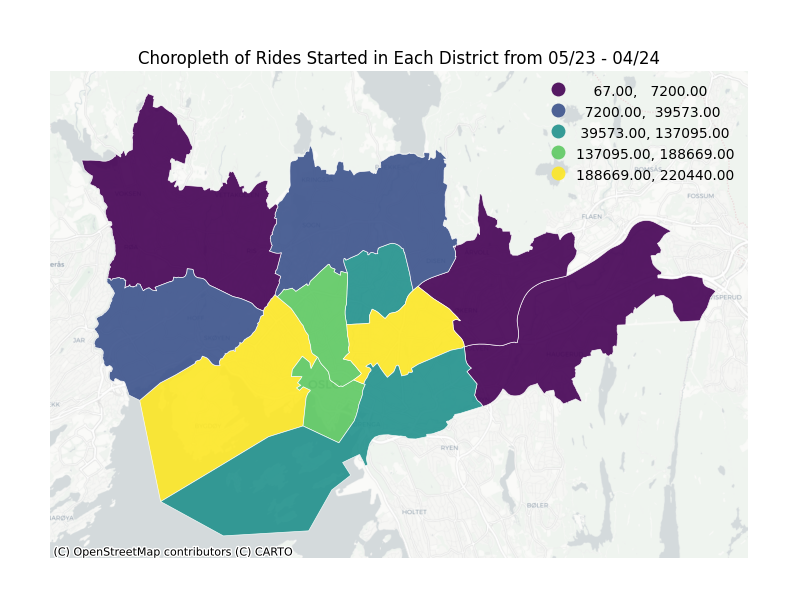

In [220]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_oslo_districts.plot(
    column="num_rides_start",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.5,
    alpha=0.9,
    legend=True,
    legend_kwds={"loc": 1},
    ax=ax,
)

plt.title("Choropleth of Rides Started in Each District from 05/23 - 04/24")
ax.set_axis_off()

cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
plt.savefig(f'figures/choropleth_rides_started.png', bbox_inches='tight', pad_inches=0)

### Morans I

In [222]:
# TODO: rename gdf_stations_choropleth everywhere used
def calculate_maximum_distance_closest_stations(gdf_stations_input):
    distances = gdf_stations_input.geometry.apply(lambda x: gdf_stations_input.distance(x))

    # For each station, find the minimum distance that is not zero
    min_distances = distances.apply(lambda x: np.min(x[x > 0]))

    # Calculate the maximum of these minimum distances
    maximum_distance = min_distances.max()

    return maximum_distance

In [224]:
maximum_distance = calculate_maximum_distance_closest_stations(gdf_stations_choropleth) 
# convert to km
maximum_distance_km = maximum_distance / 1000
print(maximum_distance)

2873.2799340722363


Moran's I: 0.26709090001534347, p-value: 0.001


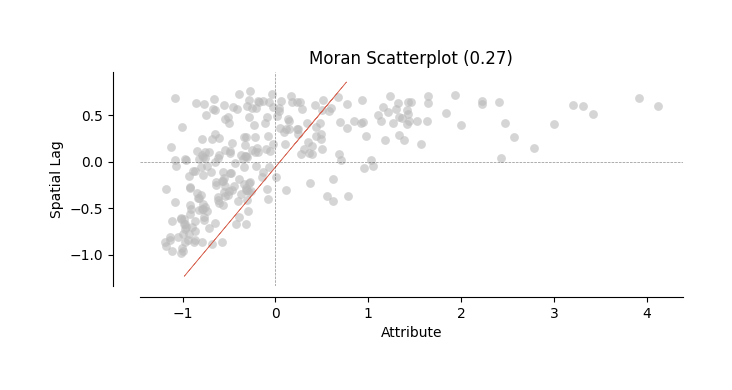

In [227]:
# TODO: move imports

# calculate Morans I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot

# weights of the stations
w = weights.DistanceBand.from_dataframe(gdf_stations_choropleth, threshold=maximum_distance, binary=True)

moran = esda.Moran(gdf_stations_choropleth['num_rides_end'], w)

print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")

# Create a Moran's plot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

### Lisa

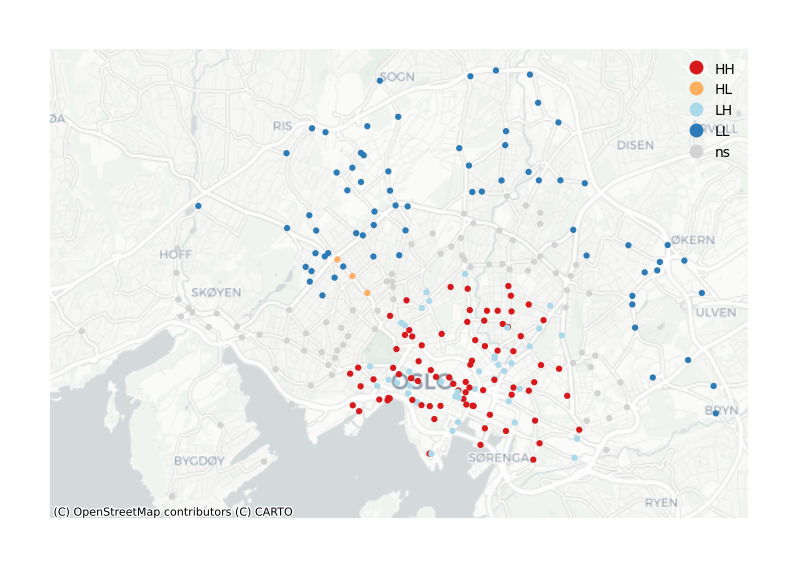

In [238]:
# TODO: move imports
from splot.esda import lisa_cluster

# Calculate local Moran's I
lisa = esda.Moran_Local(gdf_stations_choropleth['num_rides_end'], w)

# Create a LISA cluster map
fig, ax = lisa_cluster(lisa, gdf_stations_choropleth, p=0.05, figsize=(9, 9))

# add basemap
cx.add_basemap(
    ax,
    crs=gdf_oslo_districts.crs,
    source=cx.providers.CartoDB.Positron
)
plt.savefig(f'figures/lisa_cluster_map.png', bbox_inches='tight', pad_inches=0)

## Find new stations

##### Get OSM data

In [234]:
area_of_interest = 'Oslo, Norway'

# download osm data
gdf_land = ox.features_from_place(area_of_interest, tags={'landuse':True})

# Remove water geometries
gdf_land = gdf_land[gdf_land['landuse'] != 'water']

# Change the CRS of gdf_land to match that of gdf_stations
gdf_land = gdf_land.to_crs(gdf_stations.crs)

##### Find new stations to increase network density

In [261]:
n_stations = 2 # number of stations to find
n_existing_stations = gdf_stations_2024['station_id'].shape[0] # number of existing stations
n_closest_neighbours = 3 # number to calculate distance to n closest neighbours
n_stations_per_polygon = 3 # number of stations to form a polygon

# empty gdf to store new stations
new_stations = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_stations.crs) 

In [ ]:
gdf_stations_input = gdf_stations_2024.copy()
for i in range(n_stations):

    # Create all possible combinations of n stations
    combinations_of_stations = list(combinations(gdf_stations_input.geometry, n_stations_per_polygon))

    # Create polygons
    polygons = [Polygon(points) for points in tqdm(combinations_of_stations)]

    # Store polygons in a new gdf
    gdf_polygons = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_stations_input.crs)

    # Calculate the centroids of all polygons
    gdf_polygons['centroid'] = gdf_polygons['geometry'].centroid

    # Calculate the distance from each centroid to its closest n stations
    tree = cKDTree(np.array(list(zip(gdf_stations_input.geometry.x, gdf_stations_input.geometry.y))))
    distances, indices = tree.query(np.array(list(zip(gdf_polygons['centroid'].x, gdf_polygons['centroid'].y))), n_closest_neighbours)

    # TODO: add comment
    min_distances = distances.min(axis=1)
    furthest_centroids = gdf_polygons['centroid'].loc[np.argsort(min_distances)[-n_existing_stations:]]


    # Create a new GeoDataFrame for furthest_centroids
    gdf_furthest_centroids = gpd.GeoDataFrame(furthest_centroids, geometry='centroid', crs=gdf_stations_input.crs)

    # rename centroid to geometry
    gdf_furthest_centroids = gdf_furthest_centroids.rename(columns={'centroid': 'geometry'})

    for furthest_centroid in gdf_furthest_centroids['geometry']:
        print(furthest_centroid)
        # check if point is in water
        on_land = any(furthest_centroid.within(polygon) for polygon in gdf_land['geometry'])
        print("on land", on_land)
        if on_land:
            # add the new station
            gdf_stations_input = pd.concat([gdf_stations_input, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=stations_2024.crs)])
            new_stations = pd.concat([new_stations, gpd.GeoDataFrame({'geometry': [furthest_centroid]}, crs=gdf_stations_input.crs)])
            break

    

In [266]:
new_stations

geometry
0  POINT (1190175.271 8384182.493)
0  POINT (1190175.271 8384182.493)

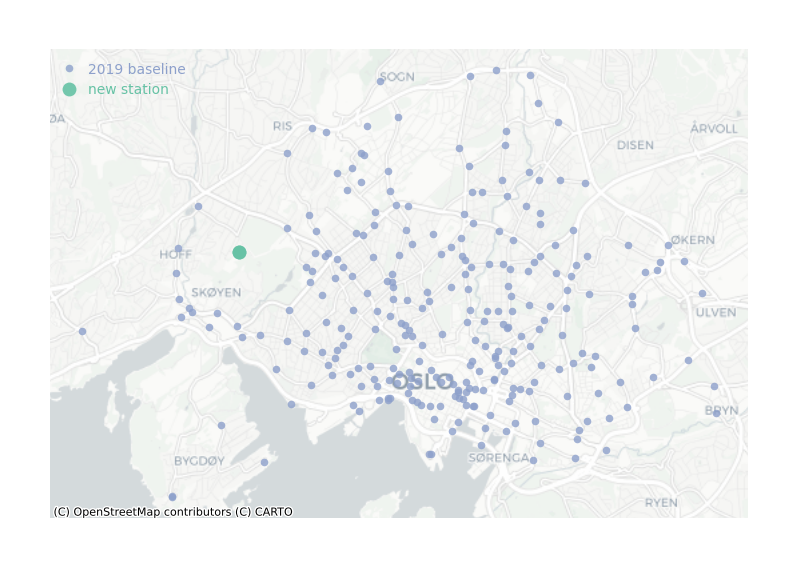

In [264]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_stations_input.plot(alpha=0.8, ax=ax, color='#8da0cb', markersize=30, label='existing stations')
new_stations.plot(alpha=0.9, ax=ax, color='#66c2a5', markersize=100, label='new stations')


ax.set_axis_off()
plt.legend(labelcolor= ['#8da0cb','#66c2a5'],loc='upper left')
cx.add_basemap(ax, crs=gdf_stations_input.crs, source=cx.providers.CartoDB.Positron)